In [3]:
# Capital Asset Pricing Model

In [167]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [169]:
# market interest rate
RISK_FREE_RATE = 0.05
# we will consider monthly returns - and we want to calculate the annual return
MONTHS_IN_YEAR = 12

In [171]:
stocks = ['IBM', '^GSPC']
start_date = '2010-01-01'
end_date = '2017-01-01'

def download_data():
    data = {}
    for stock in stocks:
        print(f"Downloading data for {stock}...")
        ticker = yf.download(stock, start_date, end_date)
        if 'Close' in ticker.columns:
            data[stock] = ticker['Close']
        else:
            print(f"Warning: 'Close' data not available for {stock}")
    return pd.concat(data, axis=1)

In [173]:
stock_data = download_data()

stock_data.columns = stock_data.columns.get_level_values(1)
print("Flattened Columns in stock_data:", stock_data.columns)
stock_data = stock_data.resample('M').last()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Flattened Columns in stock_data: Index(['IBM', '^GSPC'], dtype='object', name='Ticker')



C:\Users\souvi\AppData\Local\Temp\ipykernel_28412\1504341004.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_data = stock_data.resample('M').last()


In [175]:
print(stock_data.head())

Ticker            IBM        ^GSPC
Date                              
2010-01-31  69.630424  1073.869995
2010-02-28  72.667778  1104.489990
2010-03-31  73.290649  1169.430054
2010-04-30  73.719238  1186.689941
2010-05-31  71.948891  1089.410034


In [177]:
data = pd.DataFrame({
    's_adjclose': stock_data[stocks[0]],
    'm_adjclose': stock_data[stocks[1]]
})

In [179]:
# normalization log(n+1/n) [2/1, 3/2, .....]
data[['s_returns', 'm_returns']] = np.log(data[['s_adjclose', 'm_adjclose']] /
                                                       data[['s_adjclose', 'm_adjclose']].shift(1))

In [181]:
data

,s_adjclose,m_adjclose,s_returns,m_returns
Date,,,,
2010-01-31,69.630424,1073.869995,NaN,NaN
2010-02-28,72.667778,1104.489990,0.042696,0.028115
2010-03-31,73.290649,1169.430054,0.008535,0.057133
2010-04-30,73.719238,1186.689941,0.005831,0.014651
2010-05-31,71.948891,1089.410034,-0.024308,-0.085532
...,...,...,...,...
2016-08-31,105.663994,2170.949951,-0.002292,-0.001220
2016-09-30,105.644035,2168.270020,-0.000189,-0.001235
2016-10-31,102.212357,2126.149902,-0.033023,-0.019617


In [183]:
data = data[1:]
data

,s_adjclose,m_adjclose,s_returns,m_returns
Date,,,,
2010-02-28,72.667778,1104.489990,0.042696,0.028115
2010-03-31,73.290649,1169.430054,0.008535,0.057133
2010-04-30,73.719238,1186.689941,0.005831,0.014651
2010-05-31,71.948891,1089.410034,-0.024308,-0.085532
2010-06-30,70.926476,1030.709961,-0.014312,-0.055388
...,...,...,...,...
2016-08-31,105.663994,2170.949951,-0.002292,-0.001220
2016-09-30,105.644035,2168.270020,-0.000189,-0.001235
2016-10-31,102.212357,2126.149902,-0.033023,-0.019617


In [185]:
# covariance matrix: the diagonal items are the variances
# off diagonals are the covariances
# the matrix is symmetric: cov[0,1] = cov[1,0] !!!
covariance_matrix = np.cov(data["s_returns"], data["m_returns"])
# calculating beta according to the formula
beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
print("Beta from formula: ", beta)

Beta from formula:  0.7135079824831144


In [201]:
covariance_matrix

array([[0.00230049, 0.00093755],
       [0.00093755, 0.00131399]])

In [203]:
res = 0.00093755/0.00131399
res

0.7135138014748971

In [197]:
def plot_regression(alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20, 10))
        axis.scatter(data["m_returns"], data['s_returns'],
                     label="Data Points")
        axis.plot(data["m_returns"], beta * data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()

Beta from regression:  0.7135079824831143
Expected return:  0.0901130234911133


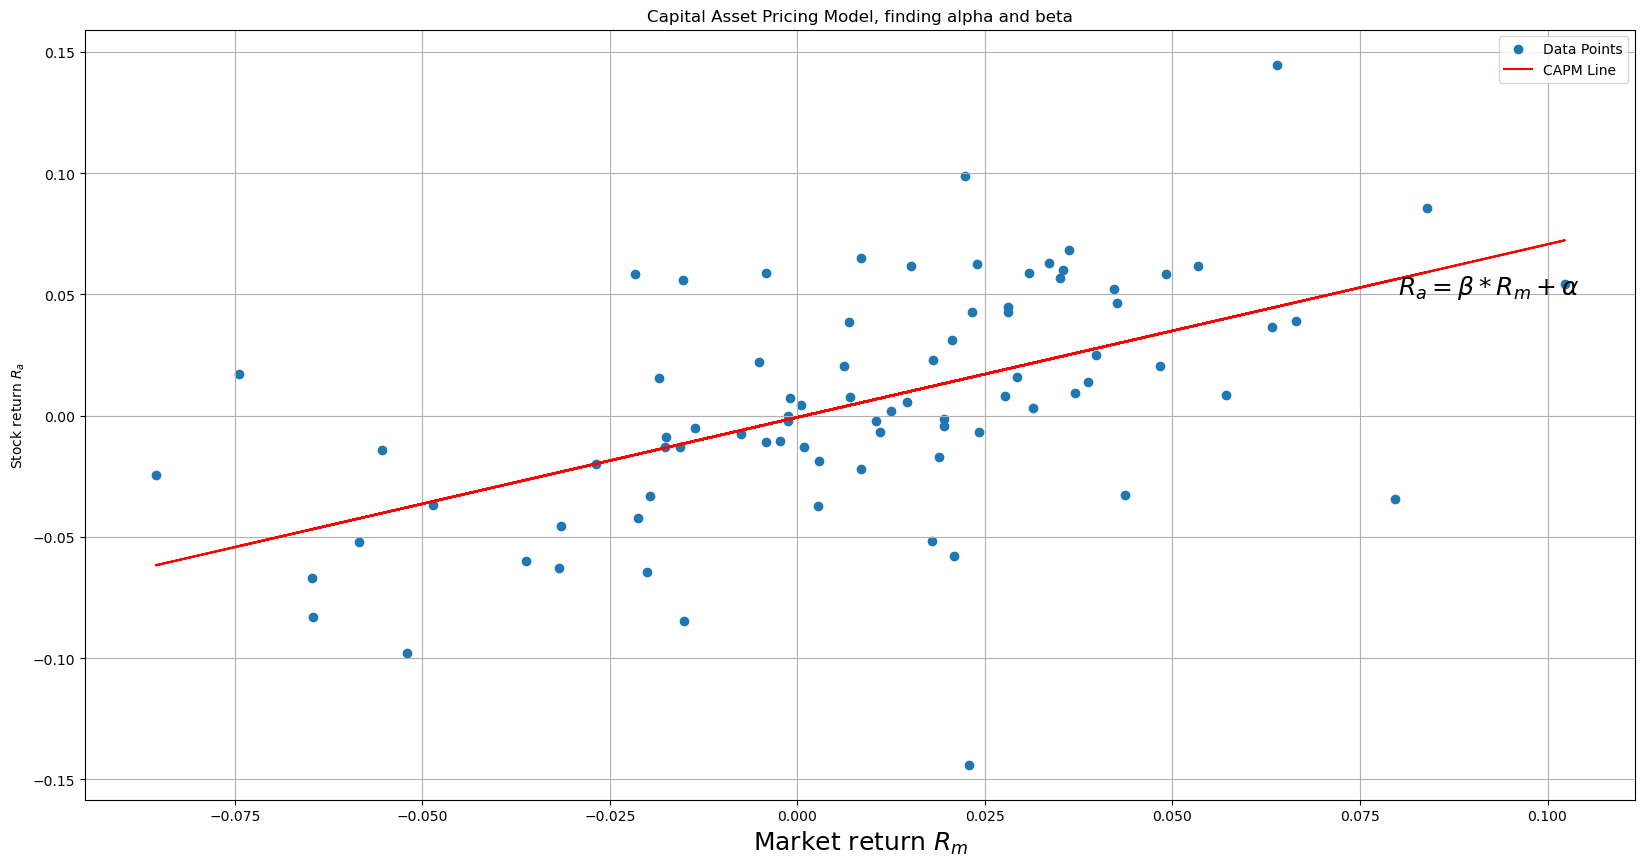

In [199]:
# using linear regression to fit a line to the data
# [stock_returns, market_returns] - slope is the beta
beta, alpha = np.polyfit(data['m_returns'], data['s_returns'], deg=1)
print("Beta from regression: ", beta)
# calculate the expected return according to the CAPM formula
# we are after annual return (this is why multiply by 12)
expected_return = RISK_FREE_RATE + beta * (data['m_returns'].mean()*MONTHS_IN_YEAR
                                           - RISK_FREE_RATE)
print("Expected return: ", expected_return)
plot_regression(alpha, beta)